### 02b_matrix_coverage_fast_ops — end-to-end, sparse-matrix engine 

**Notebook purpose (plain language)**  
This notebook swaps the *engine* that finds minimum times in `02a_coverage`.  
Instead of pandas group-bys on the long travel table, we build two *sparse* matrices and use fast, vectorised reductions. All inputs, thresholds, blue-light factors, KPIs, and maps stay the same—only the internals get faster and more scalable, enabling instant “what-if” scenarios.

---

#### What this notebook does

- **Builds matrices (reshape only, no routing):**  
  - **R** (response): rows = demand LSOAs, cols = station LSOAs, values = minutes station→LSOA.  
  - **C** (conveyance): rows = demand LSOAs, cols = acute LSOAs, values = minutes LSOA→acute.
- **Computes nearest times (vectorised, no loops):**  
  - `t_resp = rowwise_min(R[:, active_stations])`  
  - `t_conv = rowwise_min(C[:, active_acutes])`
- **Applies business rules:** blue-light factors applied *after* minima (per-leg), thresholds as in 02a.
- **Outputs unchanged:** coverage KPIs (% pop within 7/15 and 18/40), binary coverage columns, maps.
- **Adds optional diagnostic:** `t_total = t_resp + on_scene_buffer + t_conv` (three-leg view).
- **Enables scenarios:** select different station sets by column subset—no re-grouping or re-reading.

---

#### Inputs (same as 02a)

- LSOA universe (`lsoa_index`), centroids, populations (+ optional IMD / rural-urban).  
- Station & acute site files resolved to LSOA codes.  
- Long-form travel-time table already in the repo (response & conveyance legs).  
- Thresholds & blue-light factors (ARP, handover, conveyance) defined up front.

---

#### Outputs

- KPIs for response & conveyance at configured thresholds (overall and, optionally, by IMD/rural-urban).  
- Binary coverage columns per threshold for mapping.  
- (Optional) End-to-end time columns for transparency in pathway discussions.

---

#### Performance & storage

- **Sparse CSR** matrices for R and C; optional “has-edge” masks to distinguish true zeros from missing pairs.  
- **Radius thinning** (e.g., drop times > 60 min) to shrink matrices without losing feasible options.  
- **Caching:** save matrices + ordered labels to `data/.../matrices/*.npz` for instant reloads.

---

#### Scenario selector

Define scenarios as sets of active station/acute columns (e.g., `baseline`, `baseline + Site X`).  
Switching scenario = re-taking per-row minima → near-instant “what-if” diffs and coverage deltas.

---

#### Validation (first run)

- **Parity check vs 02a:** times and KPIs should match within tight tolerance on the Cornwall slice.  
- After validation, retire the legacy `min_time_from_any_origin` calls in this notebook.

---

#### Notes & cautions

- Any change to travel-time inputs **invalidates caches** → rebuild matrices.  
- LSOAs with no reachable station/acute remain at **∞** and are reported explicitly.  
- Keep LSOA codes categorical and ordering stable to avoid misalignment bugs.

---

#### Quick explainer (02a → 02b)

| Area / Step | 02a does now | 02b change | Benefit |
|---|---|---|---|
| Min times | pandas group-by on long table | rowwise min on sparse matrices | Much faster; scalable; no loops |
| Scenarios | re-filter + re-group | column subset on R/C | Instant “what-if” |
| Blue-light | applied in KPIs | apply after minima per leg | Correct nearest selection |
| Outputs | KPIs, maps | same | No UX change |



In [16]:
# Step 0a 

from __future__ import annotations

from pathlib import Path
import pandas as pd
import geopandas as gpd
import fiona

DATA_DIR = Path(
    "/Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/"
    "GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level"
)

LOOKUP_CSV = DATA_DIR / "cornwall_icb_lsoa_lookup.csv"
AGE_GPKG = DATA_DIR / "demographics_age_continuous_icb.gpkg"
# Auto-pick a sensible layer if not set elsewhere
_layers = fiona.listlayers(AGE_GPKG)
AGE_LAYER = next(
    (l for l in _layers if "continuous" in l.lower() or "lsoa" in l.lower()),
    _layers[0],
)

TRAVEL_CSV = DATA_DIR / "travel_matrix_lsoa_icb.csv"
STATIONS_CSV = DATA_DIR / "ambulance_stations_icb.csv"
ACUTE_CSV = DATA_DIR / "acute_hospitals_icb.csv"

MATRICES_DIR = DATA_DIR / "matrices"
MATRICES_DIR.mkdir(parents=True, exist_ok=True)

# Quick existence checks and small previews
paths = {
    "LOOKUP_CSV": LOOKUP_CSV,
    "AGE_GPKG": AGE_GPKG,
    "TRAVEL_CSV": TRAVEL_CSV,
    "STATIONS_CSV": STATIONS_CSV,
    "ACUTE_CSV": ACUTE_CSV,
}
missing = [k for k, p in paths.items() if not p.exists()]
if missing:
    raise FileNotFoundError(f"Missing expected file(s): {missing}")

print(f"[OK] DATA_DIR = {DATA_DIR}")
print(f"[OK] AGE_LAYER = {AGE_LAYER}")
print(f"[OK] MATRICES_DIR = {MATRICES_DIR}")

# Peek column headers to confirm schemas
print("\n[INFO] travel_matrix_lsoa_icb.csv columns (first 10):")
print(pd.read_csv(TRAVEL_CSV, nrows=1).columns.tolist()[:10])

print("\n[INFO] ambulance_stations_icb.csv columns:")
print(pd.read_csv(STATIONS_CSV, nrows=1).columns.tolist())

print("\n[INFO] acute_hospitals_icb.csv columns:")
print(pd.read_csv(ACUTE_CSV, nrows=1).columns.tolist())

print("\n[OK] Paths and schemas resolved. Re-run Step 1 now.")


[OK] DATA_DIR = /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level
[OK] AGE_LAYER = LSOA_continuous_age_icb
[OK] MATRICES_DIR = /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/matrices

[INFO] travel_matrix_lsoa_icb.csv columns (first 10):
['origin_lsoa', 'dest_lsoa', 'origin_lsoa_name', 'dest_lsoa_name', 'time_car_min']

[INFO] ambulance_stations_icb.csv columns:
['Code', 'Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'longitude', 'lsoa21cd', 'msoa21cd', 'oa21cd', 'icb_code', 'local_authority']

[INFO] acute_hospitals_icb.csv columns:
['Code', 'Name', 'Address 1', 'Address 2', 'Address 3', 'Address 4', 'Address 5', 'Postcode', 'Type', 'Parent Organisation Code', 'Parent Organisation Name', 'postcode', 'latitude', 'lo

In [17]:
# Step 1 — load, align, and clean core data for baseline matrices.
# Emits: lsoa_index, population, lsoa_g, travel, station_lsoas, acute_lsoas.
# Asserts required columns; normalises travel minutes to 'time_car_min'.
# Cleans negatives; floors off-diagonal zeros; warns on huge times/coverage gaps.
# Aligns population/geometry to the LSOA universe; prints a concise summary.

# ---------- small helpers ----------
def _ok(msg: str) -> None: print(f"[OK] {msg}")
def _warn(msg: str) -> None: print(f"[WARN] {msg}")
def _fail(msg: str) -> None: raise AssertionError(msg)

def _expect_columns(df: pd.DataFrame, cols: Iterable[str], label: str) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        _fail(f"{label}: missing columns {missing}")

# ---------- 1) LSOA universe ----------
lookup = pd.read_csv(LOOKUP_CSV, dtype={"lsoa_code": "string"})
_expect_columns(lookup, ["lsoa_code"], "LSOA lookup")
lookup = lookup.drop_duplicates(subset=["lsoa_code"]).copy()
lsoa_index = pd.Index(lookup["lsoa_code"].astype("string"), name="lsoa_code")
if lsoa_index.empty or not lsoa_index.is_unique:
    _fail("LSOA lookup must provide a non-empty, unique list of LSOA codes.")
_ok(f"Universe ready: {len(lsoa_index):,} LSOAs")

# ---------- 2) Population & geometry ----------
lsoa_g = gpd.read_file(AGE_GPKG, layer=AGE_LAYER)
_expect_columns(lsoa_g, ["lsoa_code", "geometry"], "Age GPKG")
lsoa_g["lsoa_code"] = lsoa_g["lsoa_code"].astype("string")

# Prefer total population; else sum numeric continuous ages
pop_col = next(
    (c for c in ("population_total", "population") if c in lsoa_g.columns), None
)
if pop_col:
    population = lsoa_g.set_index("lsoa_code")[pop_col].astype("float64")
else:
    age_cols: list[str] = []
    for c in lsoa_g.columns:
        if c in ("lsoa_code", "geometry"):
            continue
        if (
            re.fullmatch(r"\d{1,3}\+?", str(c))
            or str(c).startswith("age_")
        ) and np.issubdtype(lsoa_g[c].dtype, np.number):
            age_cols.append(c)
    if not age_cols:
        _fail("No population_total nor numeric continuous-age columns found.")
    population = lsoa_g.set_index("lsoa_code")[age_cols].sum(axis=1).astype(
        "float64"
    )

# Align to universe
population = population.reindex(lsoa_index).fillna(0.0)
lsoa_g = (
    lsoa_g[["lsoa_code", "geometry"]]
    .drop_duplicates("lsoa_code")
    .set_index("lsoa_code")
    .reindex(lsoa_index)
)
lsoa_g = gpd.GeoDataFrame(lsoa_g, geometry="geometry", crs=lsoa_g.crs)
_ok(
    f"Population loaded (sum={int(population.sum()):,}; "
    f"non-zero LSOAs={(population > 0).sum():,}); CRS={lsoa_g.crs}"
)

# ---------- 3) Travel table (load → inspect → clean) ----------
travel = pd.read_csv(
    TRAVEL_CSV, dtype={"origin_lsoa": "string", "dest_lsoa": "string"}
)

# Normalise time column to 'time_car_min'
time_col = next(
    (c for c in ("time_car_min", "time_min", "minutes", "drive_min", "t_min")
     if c in travel.columns),
    None,
)
if time_col is None:
    _fail("Travel CSV must include a minutes column (e.g., 'time_car_min').")
travel = travel.rename(columns={time_col: "time_car_min"})
_expect_columns(travel, ["origin_lsoa", "dest_lsoa", "time_car_min"], "Travel CSV")

# Type and NA clean
travel["origin_lsoa"] = travel["origin_lsoa"].astype("string")
travel["dest_lsoa"] = travel["dest_lsoa"].astype("string")
travel["time_car_min"] = pd.to_numeric(
    travel["time_car_min"], errors="coerce"
).astype("float32")
travel = travel.dropna(subset=["origin_lsoa", "dest_lsoa", "time_car_min"]).copy()

# Keep only rows within the LSOA universe
in_uni = travel["origin_lsoa"].isin(lsoa_index) & travel["dest_lsoa"].isin(
    lsoa_index
)
dropped_outside = int((~in_uni).sum())
if dropped_outside:
    _warn(f"Dropping {dropped_outside:,} travel rows outside LSOA universe.")
travel = travel.loc[in_uni].copy()

# Inspect problematic times
is_diag = travel["origin_lsoa"] == travel["dest_lsoa"]
is_zero = travel["time_car_min"] == 0
is_neg = travel["time_car_min"] < 0
is_large = travel["time_car_min"] > MAX_SANITY_MIN
offdiag_zero = (~is_diag) & is_zero

n_rows0 = len(travel)
n_neg = int(is_neg.sum())
n_zero_diag = int((is_diag & is_zero).sum())
n_zero_offdiag = int(offdiag_zero.sum())
n_large = int(is_large.sum())

# Clean according to flags
if DROP_NEGATIVES and n_neg:
    travel = travel.loc[~is_neg].copy()
    _warn(f"Dropped {n_neg:,} rows with negative minutes.")
if n_zero_offdiag:
    travel.loc[offdiag_zero, "time_car_min"] = np.float32(FLOOR_OFFDIAG_ZERO_MIN)
    _warn(
        f"Floored {n_zero_offdiag:,} off-diagonal zero-minute rows to "
        f"{FLOOR_OFFDIAG_ZERO_MIN} min."
    )
if not ALLOW_DIAGONAL_ZERO and n_zero_diag:
    travel.loc[is_diag & is_zero, "time_car_min"] = np.float32(
        FLOOR_OFFDIAG_ZERO_MIN
    )
    _warn(
        f"Replaced {n_zero_diag:,} diagonal zeros with "
        f"{FLOOR_OFFDIAG_ZERO_MIN} min."
    )

# Post-clean stats & coverage
n_rows1 = len(travel)
_ok(
    f"Travel rows: {n_rows1:,} (was {n_rows0:,}); "
    f"origins={travel['origin_lsoa'].nunique():,}; "
    f"dests={travel['dest_lsoa'].nunique():,}"
)
if n_large:
    _warn(
        f"{n_large:,} rows have very large minutes (>{MAX_SANITY_MIN}); kept."
    )

orig_set = pd.Index(travel["origin_lsoa"].unique(), dtype="string")
dest_set = pd.Index(travel["dest_lsoa"].unique(), dtype="string")
miss_orig = lsoa_index.difference(orig_set)
miss_dest = lsoa_index.difference(dest_set)
if len(miss_orig):
    _warn(f"{len(miss_orig)} LSOAs absent as origins (e.g., {list(miss_orig[:5])})")
if len(miss_dest):
    _warn(f"{len(miss_dest)} LSOAs absent as dests (e.g., {list(miss_dest[:5])})")

# ---------- 4) Sites (stations & acutes resolved to LSOA) ----------
def _load_site_lsoas(csv_path: Path, label: str) -> pd.Index:
    if not csv_path.exists():
        if label.lower().startswith("acute"):
            _warn("Acute CSV not found; conveyance leg will be optional.")
            return pd.Index([], dtype="string", name="lsoa_code")
        _fail(f"{label} CSV not found: {csv_path}")
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]
    code_col = next((c for c in ("lsoa_code", "lsoa21cd") if c in df.columns), None)
    if code_col is None:
        _fail(f"{label}: expected 'lsoa_code' or 'lsoa21cd'.")
    codes = (
        pd.Index(df[code_col].astype("string"), name="lsoa_code")
        .dropna()
        .drop_duplicates()
    )
    codes = codes[codes.isin(lsoa_index)]
    if codes.empty:
        _warn(f"{label}: no valid LSOAs after filtering to universe.")
    return codes

station_lsoas = _load_site_lsoas(STATIONS_CSV, "Ambulance stations")
acute_lsoas = _load_site_lsoas(ACUTE_CSV, "Acute hospitals")
_ok(
    f"Stations mapped to {len(station_lsoas):,} LSOAs; "
    f"Acutes mapped to {len(acute_lsoas):,} LSOAs"
)

# Ensure coverage in travel table for sites we’ll need later
missing_station_as_origin = station_lsoas.difference(orig_set)
missing_acute_as_dest = acute_lsoas.difference(dest_set)
if len(missing_station_as_origin):
    _warn(
        f"{len(missing_station_as_origin)} station LSOAs not present as travel "
        f"origins (e.g., {list(missing_station_as_origin[:5])})."
    )
if len(missing_acute_as_dest):
    _warn(
        f"{len(missing_acute_as_dest)} acute LSOAs not present as travel "
        f"destinations (e.g., {list(missing_acute_as_dest[:5])})."
    )

# ---------- 5) Report diagonals & zero counts explicitly ----------
diag_zero_ct = int((is_diag & is_zero).sum())
offdiag_zero_ct = int((~is_diag & is_zero).sum())
_ok(
    f"Diagonal 0-min rows kept: {diag_zero_ct:,} "
    f"(ALLOW_DIAGONAL_ZERO={ALLOW_DIAGONAL_ZERO})"
)
if offdiag_zero_ct:
    _warn(
        f"Off-diagonal 0-min rows remaining after cleaning: {offdiag_zero_ct:,}"
    )

# ---------- 6) Step 1 summary ----------
summary = pd.Series(
    {
        "n_lsoas": len(lsoa_index),
        "population_sum": int(population.sum()),
        "travel_rows": len(travel),
        "unique_origins": travel["origin_lsoa"].nunique(),
        "unique_dests": travel["dest_lsoa"].nunique(),
        "zeros_diag": diag_zero_ct,
        "zeros_offdiag": offdiag_zero_ct,
        "n_station_lsoas": len(station_lsoas),
        "n_acute_lsoas": len(acute_lsoas),
    }
)
print("\n== STEP 1 SUMMARY (cleaned) ==")
print(summary.to_string())
_ok("Step 1 complete — ready to build sparse matrices (Step 2).")


[OK] Universe ready: 336 LSOAs
[OK] Population loaded (sum=575,628; non-zero LSOAs=336); CRS=EPSG:27700
[WARN] Floored 41 off-diagonal zero-minute rows to 0.5 min.
[OK] Travel rows: 112,560 (was 112,560); origins=336; dests=336
[OK] Stations mapped to 14 LSOAs; Acutes mapped to 3 LSOAs
[OK] Diagonal 0-min rows kept: 0 (ALLOW_DIAGONAL_ZERO=True)
[WARN] Off-diagonal 0-min rows remaining after cleaning: 41

== STEP 1 SUMMARY (cleaned) ==
n_lsoas               336
population_sum     575628
travel_rows        112560
unique_origins        336
unique_dests          336
zeros_diag              0
zeros_offdiag          41
n_station_lsoas        14
n_acute_lsoas           3
[OK] Step 1 complete — ready to build sparse matrices (Step 2).


In [18]:
# Step 2 — build & cache sparse matrices (R: station→LSOA, C: LSOA→acute)
# Baseline-only: creates CSR matrices + boolean masks, saves to MATRICES_DIR,
# and prints concise sanity stats (nearest times & coverage bands).

from __future__ import annotations

from typing import Dict, Sequence, Tuple
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import sparse

# ---- helpers ---------------------------------------------------------------

def _build_sparse_matrix(
    travel_df: pd.DataFrame,
    row_codes: pd.Index,
    col_codes: pd.Index,
    row_key: str,
    col_key: str,
    value_key: str = "time_car_min",
    max_radius: float | None = MAX_RADIUS_MIN,
) -> Tuple[sparse.csr_matrix, sparse.csr_matrix]:
    """
    Reshape long travel table into CSR minutes + boolean mask (same sparsity).
    Rows = row_codes, Cols = col_codes.
    """
    if len(col_codes) == 0:
        shape = (len(row_codes), 0)
        return (sparse.csr_matrix(shape, dtype=np.float32),
                sparse.csr_matrix(shape, dtype=np.uint8))

    idx_row = row_codes.astype("string")
    idx_col = col_codes.astype("string")
    m = travel_df[row_key].isin(idx_row) & travel_df[col_key].isin(idx_col)

    df = travel_df.loc[m, [row_key, col_key, value_key]].dropna(
        subset=[value_key]
    ).copy()

    if max_radius is not None:
        df = df.loc[df[value_key] <= float(max_radius)].copy()

    df = (
        df.groupby([row_key, col_key], observed=True, sort=False)[value_key]
        .min()
        .reset_index()
    )

    row_lookup: Dict[str, int] = {code: i for i, code in enumerate(idx_row)}
    col_lookup: Dict[str, int] = {code: j for j, code in enumerate(idx_col)}

    rows = df[row_key].map(row_lookup).to_numpy(dtype=np.int32, na_value=-1)
    cols = df[col_key].map(col_lookup).to_numpy(dtype=np.int32, na_value=-1)
    vals = df[value_key].astype(np.float32).to_numpy()

    good = (rows >= 0) & (cols >= 0) & np.isfinite(vals)
    rows, cols, vals = rows[good], cols[good], vals[good]

    shape = (len(row_codes), len(col_codes))
    coo = sparse.coo_matrix((vals, (rows, cols)), shape=shape, dtype=np.float32)
    mat = coo.tocsr()

    mask = sparse.csr_matrix(
        (np.ones_like(mat.data, dtype=np.uint8), mat.indices, mat.indptr),
        shape=mat.shape,
    )
    return mat, mask


def _rowwise_min_with_mask(
    mat: sparse.csr_matrix, mask: sparse.csr_matrix
) -> np.ndarray:
    """Row-wise minima treating 'no edge' as +inf. Returns float32 vector."""
    if mat.shape[1] == 0:
        return np.full(mat.shape[0], np.inf, dtype=np.float32)
    arr = mat.toarray()
    arr_mask = mask.toarray().astype(bool)
    arr[~arr_mask] = np.inf
    return arr.min(axis=1).astype(np.float32)


def _pct_covered(
    times_min: np.ndarray, threshold_min: float, weights: np.ndarray
) -> float:
    """Weighted percent of population with times <= threshold."""
    w = weights.astype(np.float64)
    covered = times_min <= threshold_min
    covered_pop = (w * covered).sum()
    total_pop = w.sum()
    return float(covered_pop / total_pop * 100.0) if total_pop > 0 else 0.0


def _report_matrix(name: str, mat: sparse.csr_matrix) -> None:
    nnz = mat.nnz
    m, n = mat.shape
    density = nnz / (m * n) if (m > 0 and n > 0) else 0.0
    print(f"[OK] {name}: shape={mat.shape}, nnz={nnz:,}, density={density:.4f}")


# ---- build R (station→LSOA) & C (LSOA→acute) ------------------------------

R, R_mask = _build_sparse_matrix(
    travel_df=travel,
    row_codes=lsoa_index,          # rows: demand LSOAs
    col_codes=station_lsoas,       # cols: station LSOAs
    row_key="dest_lsoa",           # want station(origin)→demand(dest)
    col_key="origin_lsoa",
    value_key="time_car_min",
    max_radius=MAX_RADIUS_MIN,
)

C, C_mask = _build_sparse_matrix(
    travel_df=travel,
    row_codes=lsoa_index,          # rows: demand LSOAs
    col_codes=acute_lsoas,         # cols: acute LSOAs
    row_key="origin_lsoa",         # want demand(origin)→acute(dest)
    col_key="dest_lsoa",
    value_key="time_car_min",
    max_radius=MAX_RADIUS_MIN,
)

_report_matrix("R (station→LSOA)", R)
_report_matrix("C (LSOA→acute)", C)

# ---- cache matrices & metadata --------------------------------------------

sparse.save_npz(MATRICES_DIR / "R_response_csr.npz", R)
sparse.save_npz(MATRICES_DIR / "R_response_mask_csr.npz", R_mask)
sparse.save_npz(MATRICES_DIR / "C_convey_csr.npz", C)
sparse.save_npz(MATRICES_DIR / "C_convey_mask_csr.npz", C_mask)

np.savez(
    MATRICES_DIR / "matrix_metadata.npz",
    lsoa_index=lsoa_index.to_numpy(),
    station_lsoas=station_lsoas.to_numpy(),
    acute_lsoas=acute_lsoas.to_numpy(),
    response_thresholds=np.array(RESPONSE_THRESHOLDS, dtype=np.int32),
    scene_to_ae_thresholds=np.array(SCENE_TO_AE_THRESHOLDS, dtype=np.int32),
    blue_light_factors=np.array(
        [BLUE_LIGHT_FACTOR_RESPONSE, BLUE_LIGHT_FACTOR_CONVEY], dtype=np.float32
    ),
    max_radius=np.array(
        [np.nan if MAX_RADIUS_MIN is None else float(MAX_RADIUS_MIN)],
        dtype=np.float32,
    ),
)
print(f"[OK] Cached matrices to: {MATRICES_DIR}")

# ---- baseline sanity: nearest times & coverage -----------------------------

t_resp_base = _rowwise_min_with_mask(R, R_mask) * np.float32(
    BLUE_LIGHT_FACTOR_RESPONSE
)
t_conv_base = _rowwise_min_with_mask(C, C_mask) * np.float32(
    BLUE_LIGHT_FACTOR_CONVEY
)

def _summ(name: str, arr: np.ndarray) -> str:
    finite = np.isfinite(arr)
    if not finite.any():
        return f"{name}: all inf"
    vals = arr[finite]
    q = np.percentile(vals, [0, 25, 50, 90, 95, 100]).round(2)
    return (
        f"{name}: min={q[0]}, p25={q[1]}, median={q[2]}, p90={q[3]}, "
        f"p95={q[4]}, max={q[5]} (n={finite.sum()})"
    )

print(_summ("t_resp (min to any station)", t_resp_base))
print(_summ("t_conv (min to any acute)", t_conv_base))

pop_w = population.reindex(lsoa_index).to_numpy(dtype=np.float64)

def _coverage_report(
    times: np.ndarray, thresholds: Sequence[int], label: str
) -> None:
    parts = []
    for thr in thresholds:
        pct = _pct_covered(times, thr, pop_w)
        parts.append(f"≤{thr} min: {pct:5.1f}%")
    print(f"{label}: " + " | ".join(parts))

_coverage_report(t_resp_base, RESPONSE_THRESHOLDS, "Response coverage (all stations)")
if C.shape[1] > 0:
    _coverage_report(
        t_conv_base, SCENE_TO_AE_THRESHOLDS, "Conveyance coverage (all acutes)"
    )
else:
    print("[WARN] No acute columns; conveyance coverage skipped.")

# Optionally persist baseline min-times for downstream notebooks
np.savez(
    MATRICES_DIR / "baseline_min_times.npz",
    t_resp_base=t_resp_base,
    t_conv_base=t_conv_base,
)
print("[OK] Step 2 complete — matrices cached; baseline sanity computed.")


[OK] R (station→LSOA): shape=(336, 14), nnz=4,690, density=0.9970
[OK] C (LSOA→acute): shape=(336, 3), nnz=1,005, density=0.9970
[OK] Cached matrices to: /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/matrices
t_resp (min to any station): min=0.5, p25=5.7, median=11.22, p90=24.64, p95=28.76, max=92.22 (n=336)
t_conv (min to any acute): min=0.5, p25=16.95, median=29.28, p90=74.47, p95=80.82, max=129.12 (n=336)
Response coverage (all stations): ≤7 min:  30.8% | ≤15 min:  62.3% | ≤18 min:  75.2% | ≤40 min:  99.3%
Conveyance coverage (all acutes): ≤30 min:  51.8% | ≤45 min:  69.4% | ≤60 min:  79.0%
[OK] Step 2 complete — matrices cached; baseline sanity computed.


In [19]:
# Step 3 — baseline coverage tables & LSOA flags (no scenarios).
# Builds pop-weighted coverage table; exports per-LSOA min times + flags;
# saves CSVs/NPZ to DATA_DIR/{tables,matrices}. No maps here.

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

TABLES_DIR = DATA_DIR / "tables"
TABLES_DIR.mkdir(parents=True, exist_ok=True)

# Safety: define _pct_covered locally if not present
if "_pct_covered" not in globals():
    def _pct_covered(
        times_min: np.ndarray, threshold_min: float, weights: np.ndarray
    ) -> float:
        w = weights.astype(np.float64)
        covered = np.isfinite(times_min) & (times_min <= threshold_min)
        covered_pop = (w * covered).sum()
        total_pop = w.sum()
        return float(covered_pop / total_pop * 100.0) if total_pop > 0 else 0.0

# --- Inputs from Steps 1–2
pop_w = population.reindex(lsoa_index).to_numpy(dtype=np.float64)

# --- Coverage table (population-weighted % covered at each band)
rows: list[dict] = []
for thr in RESPONSE_THRESHOLDS:
    rows.append(
        {
            "metric": "response",
            "threshold_min": int(thr),
            "pop_covered_pct": _pct_covered(t_resp_base, thr, pop_w),
            "population_total": int(pop_w.sum()),
        }
    )

if C.shape[1] > 0 and np.isfinite(t_conv_base).any():
    for thr in SCENE_TO_AE_THRESHOLDS:
        rows.append(
            {
                "metric": "conveyance",
                "threshold_min": int(thr),
                "pop_covered_pct": _pct_covered(t_conv_base, thr, pop_w),
                "population_total": int(pop_w.sum()),
            }
        )
else:
    print("[WARN] Conveyance coverage skipped (no finite acute times).")

coverage_df = pd.DataFrame(rows).sort_values(["metric", "threshold_min"]).reset_index(drop=True)
coverage_path = TABLES_DIR / "baseline_coverage.csv"
coverage_df.to_csv(coverage_path, index=False)
print(f"[OK] Saved baseline coverage table → {coverage_path}")

# --- Per-LSOA min times and binary flags
lsoa_out = pd.DataFrame(
    {
        "lsoa_code": lsoa_index,
        "t_resp_min": t_resp_base.astype("float32"),
        "t_conv_min": t_conv_base.astype("float32"),
        "population": population.reindex(lsoa_index).to_numpy(dtype=np.float64),
    }
)

for thr in RESPONSE_THRESHOLDS:
    lsoa_out[f"resp_le_{thr}"] = (
        np.isfinite(lsoa_out["t_resp_min"].to_numpy()) &
        (lsoa_out["t_resp_min"].to_numpy() <= thr)
    ).astype("int8")

if C.shape[1] > 0 and np.isfinite(t_conv_base).any():
    for thr in SCENE_TO_AE_THRESHOLDS:
        lsoa_out[f"conv_le_{thr}"] = (
            np.isfinite(lsoa_out["t_conv_min"].to_numpy()) &
            (lsoa_out["t_conv_min"].to_numpy() <= thr)
        ).astype("int8")

flags_csv = TABLES_DIR / "lsoa_flags_baseline.csv"
lsoa_out.to_csv(flags_csv, index=False)
print(f"[OK] Saved LSOA baseline flags → {flags_csv}")

# --- Optional GeoPackage for mapping notebooks (separate step will plot)
gpkg_path = DATA_DIR / "lsoa_flags_baseline.gpkg"
lsoa_flags_g = lsoa_g.join(
    lsoa_out.set_index("lsoa_code"), how="left"
).reset_index()
# Keep times as float; NaNs are fine for missing conveyance legs
lsoa_flags_g.to_file(gpkg_path, driver="GPKG", layer="baseline_flags", encoding="utf-8")
print(f"[OK] Saved GeoPackage layer → {gpkg_path} :: baseline_flags")

# --- Monotonicity check (coverage should rise with threshold)
def _is_monotone_non_decreasing(vals: list[float]) -> bool:
    return all(b >= a - 1e-9 for a, b in zip(vals, vals[1:]))

resp_vals = coverage_df.query("metric == 'response'")["pop_covered_pct"].tolist()
if not _is_monotone_non_decreasing(resp_vals):
    print("[WARN] Response coverage not monotone across thresholds.")

if "conveyance" in coverage_df["metric"].unique():
    conv_vals = coverage_df.query("metric == 'conveyance'")["pop_covered_pct"].tolist()
    if not _is_monotone_non_decreasing(conv_vals):
        print("[WARN] Conveyance coverage not monotone across thresholds.")

print("[OK] Step 3 complete — baseline tables and LSOA flags exported.")


[OK] Saved baseline coverage table → /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/tables/baseline_coverage.csv
[OK] Saved LSOA baseline flags → /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/tables/lsoa_flags_baseline.csv
[OK] Saved GeoPackage layer → /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/lsoa_flags_baseline.gpkg :: baseline_flags
[OK] Step 3 complete — baseline tables and LSOA flags exported.


[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/maps/baseline_response_le_15_geopandas.png
[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/maps/baseline_convey_le_60_geopandas.png


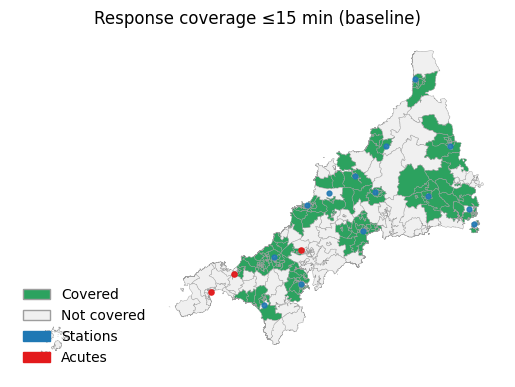

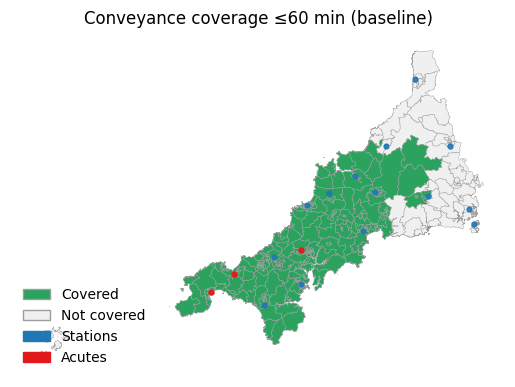

In [23]:
# Step 4 — GeoPandas-only baseline maps (no OSM/basemaps)

from __future__ import annotations
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

MAPS_DIR = DATA_DIR / "maps"
MAPS_DIR.mkdir(parents=True, exist_ok=True)

# Load flags if needed
if "lsoa_flags_g" not in globals():
    lsoa_flags_g = gpd.read_file(DATA_DIR / "lsoa_flags_baseline.gpkg",
                                 layer="baseline_flags")

# Use a projected CRS for crisp, undistorted shapes (BNG if available)
g_plot = lsoa_flags_g.to_crs(epsg=27700) if lsoa_flags_g.crs else lsoa_flags_g

# Station/acute centroids from Step 1 geometry
stations_g = lsoa_g.loc[station_lsoas].to_crs(g_plot.crs).copy()
stations_g["geometry"] = stations_g.geometry.centroid
acutes_g = (lsoa_g.loc[acute_lsoas].to_crs(g_plot.crs).copy()
            if len(acute_lsoas) else gpd.GeoDataFrame(geometry=[], crs=g_plot.crs))
if len(acutes_g):
    acutes_g["geometry"] = acutes_g.geometry.centroid

# Colours
COVER = "#2ca25f"    # green
UNCOVER = "#f0f0f0"  # light grey
BORDER = "#9e9e9e"   # grey
STN = "#1f78b4"      # blue
ACU = "#e31a1c"      # red

def make_binary_map(gdf: gpd.GeoDataFrame, col: str, title: str, outfile: str) -> None:
    if col not in gdf.columns:
        raise KeyError(f"Missing column '{col}' in baseline flags.")
    face_col = gdf[col].map({1: COVER, 0: UNCOVER}).fillna(UNCOVER)

    fig = plt.figure(figsize=(9, 9))
    ax = gdf.plot(color=face_col, edgecolor=BORDER, linewidth=0.3)
    stations_g.plot(ax=ax, color=STN, markersize=12, alpha=0.9)

    if len(acutes_g):
        acutes_g.plot(ax=ax, color=ACU, markersize=14, alpha=0.95)

    ax.set_axis_off()
    ax.set_title(title, pad=8)

    legend_patches = [
        Patch(facecolor=COVER, edgecolor=BORDER, label="Covered"),
        Patch(facecolor=UNCOVER, edgecolor=BORDER, label="Not covered"),
        Patch(facecolor=STN, edgecolor=STN, label="Stations"),
    ]
    if len(acutes_g):
        legend_patches.append(Patch(facecolor=ACU, edgecolor=ACU, label="Acutes"))

    ax.legend(handles=legend_patches, frameon=False, loc="lower left")
    fig.savefig(MAPS_DIR / outfile, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"[OK] Saved {MAPS_DIR / outfile}")

# Pick default bands (falls back to last if not present)
resp_band = 15 if 15 in RESPONSE_THRESHOLDS else RESPONSE_THRESHOLDS[-1]
conv_band = 60 if 60 in SCENE_TO_AE_THRESHOLDS else SCENE_TO_AE_THRESHOLDS[-1]

make_binary_map(
    g_plot, f"resp_le_{resp_band}",
    f"Response coverage ≤{resp_band} min (baseline)",
    f"baseline_response_le_{resp_band}_geopandas.png",
)

if len(acute_lsoas) and f"conv_le_{conv_band}" in g_plot.columns:
    make_binary_map(
        g_plot, f"conv_le_{conv_band}",
        f"Conveyance coverage ≤{conv_band} min (baseline)",
        f"baseline_convey_le_{conv_band}_geopandas.png",
    )
else:
    print("[WARN] Conveyance map skipped (no acute flags or sites).")


In [21]:
# Step 5 — baseline QA summary & README (no scenarios).
# Produces: coverage_summary.csv and COVERAGE_README.md under DATA_DIR.
# Summarises counts, matrix shapes/densities, quantiles, and coverage bands.

from __future__ import annotations

from pathlib import Path
from datetime import datetime
import os
import numpy as np
import pandas as pd

TABLES_DIR = (DATA_DIR / "tables")
TABLES_DIR.mkdir(parents=True, exist_ok=True)

def _quantiles(arr: np.ndarray) -> dict[str, float]:
    finite = np.isfinite(arr)
    if not finite.any():
        return {"min": np.inf, "p25": np.inf, "median": np.inf,
                "p90": np.inf, "p95": np.inf, "max": np.inf, "n": 0}
    vals = arr[finite]
    q = np.percentile(vals, [0, 25, 50, 90, 95, 100]).round(2)
    return {"min": float(q[0]), "p25": float(q[1]), "median": float(q[2]),
            "p90": float(q[3]), "p95": float(q[4]), "max": float(q[5]),
            "n": int(finite.sum())}

# Load coverage table from Step 3 (preferred); else compute on the fly
cov_csv = TABLES_DIR / "baseline_coverage.csv"
if cov_csv.exists():
    coverage_df = pd.read_csv(cov_csv)
else:
    pop_w = population.reindex(lsoa_index).to_numpy(dtype=np.float64)
    rows = []
    for thr in RESPONSE_THRESHOLDS:
        covered = (t_resp_base <= thr)
        rows.append({
            "metric": "response",
            "threshold_min": int(thr),
            "pop_covered_pct":
                float((pop_w * covered).sum() / pop_w.sum() * 100.0),
        })
    if C.shape[1] > 0 and np.isfinite(t_conv_base).any():
        for thr in SCENE_TO_AE_THRESHOLDS:
            covered = (t_conv_base <= thr)
            rows.append({
                "metric": "conveyance",
                "threshold_min": int(thr),
                "pop_covered_pct":
                    float((pop_w * covered).sum() / pop_w.sum() * 100.0),
            })
    coverage_df = pd.DataFrame(rows).sort_values(
        ["metric", "threshold_min"]
    ).reset_index(drop=True)

# Build a compact summary CSV
resp_q = _quantiles(t_resp_base)
conv_q = _quantiles(t_conv_base) if C.shape[1] else None

rows = [
    {"section": "counts", "key": "n_lsoas", "value": len(lsoa_index)},
    {"section": "counts", "key": "n_station_lsoas", "value": len(station_lsoas)},
    {"section": "counts", "key": "n_acute_lsoas", "value": len(acute_lsoas)},
    {"section": "matrix_R", "key": "shape", "value": f"{R.shape}"},
    {"section": "matrix_R", "key": "nnz", "value": R.nnz},
    {"section": "matrix_R", "key": "density",
     "value": round(R.nnz / (R.shape[0]*max(R.shape[1],1)), 6)},
    {"section": "matrix_C", "key": "shape", "value": f"{C.shape}"},
    {"section": "matrix_C", "key": "nnz", "value": C.nnz},
    {"section": "matrix_C", "key": "density",
     "value": round(C.nnz / (C.shape[0]*max(C.shape[1],1)), 6)},
    {"section": "factors", "key": "BLUE_LIGHT_FACTOR_RESPONSE",
     "value": BLUE_LIGHT_FACTOR_RESPONSE},
    {"section": "factors", "key": "BLUE_LIGHT_FACTOR_CONVEY",
     "value": BLUE_LIGHT_FACTOR_CONVEY},
    {"section": "build", "key": "MAX_RADIUS_MIN", "value": MAX_RADIUS_MIN},
    {"section": "cleaning", "key": "ALLOW_DIAGONAL_ZERO",
     "value": ALLOW_DIAGONAL_ZERO},
    {"section": "cleaning", "key": "FLOOR_OFFDIAG_ZERO_MIN",
     "value": FLOOR_OFFDIAG_ZERO_MIN},
    {"section": "cleaning", "key": "DROP_NEGATIVES", "value": DROP_NEGATIVES},
    {"section": "cleaning", "key": "MAX_SANITY_MIN", "value": MAX_SANITY_MIN},
    {"section": "quantiles_response", "key": "min", "value": resp_q["min"]},
    {"section": "quantiles_response", "key": "p25", "value": resp_q["p25"]},
    {"section": "quantiles_response", "key": "median", "value": resp_q["median"]},
    {"section": "quantiles_response", "key": "p90", "value": resp_q["p90"]},
    {"section": "quantiles_response", "key": "p95", "value": resp_q["p95"]},
    {"section": "quantiles_response", "key": "max", "value": resp_q["max"]},
]
if conv_q:
    rows += [
        {"section": "quantiles_convey", "key": "min", "value": conv_q["min"]},
        {"section": "quantiles_convey", "key": "p25", "value": conv_q["p25"]},
        {"section": "quantiles_convey", "key": "median",
         "value": conv_q["median"]},
        {"section": "quantiles_convey", "key": "p90", "value": conv_q["p90"]},
        {"section": "quantiles_convey", "key": "p95", "value": conv_q["p95"]},
        {"section": "quantiles_convey", "key": "max", "value": conv_q["max"]},
    ]

summary_df = pd.DataFrame(rows)
summary_csv = DATA_DIR / "coverage_summary.csv"
summary_df.to_csv(summary_csv, index=False)
print(f"[OK] Saved summary → {summary_csv}")

# Write a concise README
def _fsize(path: Path) -> str:
    try:
        b = os.path.getsize(path)
        return f"{b/1_048_576:.2f} MB"
    except OSError:
        return "n/a"

ts = datetime.now().strftime("%Y-%m-%d %H:%M")
readme = DATA_DIR / "COVERAGE_README.md"
md = []
md.append(f"# Baseline coverage build\n\n_Run: {ts}_\n")
md.append("## Data & config\n")
md.append(f"- LSOAs: **{len(lsoa_index)}**  | "
          f"Stations: **{len(station_lsoas)}**  | "
          f"Acutes: **{len(acute_lsoas)}**")
md.append(f"- Response thresholds: {list(RESPONSE_THRESHOLDS)} minutes")
md.append(f"- Conveyance thresholds: {list(SCENE_TO_AE_THRESHOLDS)} minutes")
md.append(f"- Blue-light factors: response={BLUE_LIGHT_FACTOR_RESPONSE}, "
          f"convey={BLUE_LIGHT_FACTOR_CONVEY}")
md.append(f"- MAX_RADIUS_MIN: {MAX_RADIUS_MIN}")
md.append(f"- Cleaning: ALLOW_DIAGONAL_ZERO={ALLOW_DIAGONAL_ZERO}, "
          f"FLOOR_OFFDIAG_ZERO_MIN={FLOOR_OFFDIAG_ZERO_MIN}, "
          f"DROP_NEGATIVES={DROP_NEGATIVES}, MAX_SANITY_MIN={MAX_SANITY_MIN}\n")

md.append("## Matrices\n")
md.append(f"- R (station→LSOA): shape {R.shape}, nnz {R.nnz:,}, "
          f"density {summary_df.query('section==\"matrix_R\" and key==\"density\"')['value'].iloc[0]}")
md.append(f"- C (LSOA→acute): shape {C.shape}, nnz {C.nnz:,}, "
          f"density {summary_df.query('section==\"matrix_C\" and key==\"density\"')['value'].iloc[0]}")
md.append(f"- Files: R={_fsize(MATRICES_DIR / 'R_response_csr.npz')}, "
          f"C={_fsize(MATRICES_DIR / 'C_convey_csr.npz')}\n")

md.append("## Quantiles (minutes)\n")
md.append(f"- Response: min {resp_q['min']}, p25 {resp_q['p25']}, "
          f"median {resp_q['median']}, p90 {resp_q['p90']}, "
          f"p95 {resp_q['p95']}, max {resp_q['max']} (n={resp_q['n']})")
if conv_q:
    md.append(f"- Conveyance: min {conv_q['min']}, p25 {conv_q['p25']}, "
              f"median {conv_q['median']}, p90 {conv_q['p90']}, "
              f"p95 {conv_q['p95']}, max {conv_q['max']} (n={conv_q['n']})\n")

md.append("## Coverage (% population ≤ band)\n")
md.append(coverage_df.to_string(index=False))

readme.write_text("\n".join(md), encoding="utf-8")
print(f"[OK] Wrote README → {readme}")

print("[OK] Step 5 complete — baseline QA summary and README generated.")


[OK] Saved summary → /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/coverage_summary.csv
[OK] Wrote README → /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/COVERAGE_README.md
[OK] Step 5 complete — baseline QA summary and README generated.


In [22]:
# Step 6 — baseline charts (coverage bars + ECDFs); saves to DATA_DIR/charts
# Requires: coverage_df (from Step 3), t_resp_base, t_conv_base, thresholds.

from __future__ import annotations

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CHARTS_DIR = DATA_DIR / "charts"
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

# Load coverage if not in memory
coverage_path = DATA_DIR / "tables" / "baseline_coverage.csv"
if "coverage_df" not in globals():
    if coverage_path.exists():
        coverage_df = pd.read_csv(coverage_path)
    else:
        raise FileNotFoundError(
            f"Coverage table not found: {coverage_path}. "
            "Run Step 3 first."
        )

# ---------- 6.1 Response coverage bar chart ----------
resp_cov = (
    coverage_df.query("metric == 'response'")
    .sort_values("threshold_min")
    .reset_index(drop=True)
)
fig = plt.figure(figsize=(6, 4))
plt.bar(
    resp_cov["threshold_min"].astype(int).astype(str),
    resp_cov["pop_covered_pct"],
)
plt.ylabel("Population covered (%)")
plt.xlabel("Response threshold (minutes)")
plt.title("Baseline response coverage by threshold")
plt.ylim(0, 100)
plt.grid(axis="y", alpha=0.3)
out = CHARTS_DIR / "baseline_response_coverage_bars.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.close(fig)
print(f"[OK] Saved {out}")

# ---------- 6.2 Conveyance coverage bar chart (if available) ----------
if "conveyance" in coverage_df["metric"].unique():
    conv_cov = (
        coverage_df.query("metric == 'conveyance'")
        .sort_values("threshold_min")
        .reset_index(drop=True)
    )
    fig = plt.figure(figsize=(6, 4))
    plt.bar(
        conv_cov["threshold_min"].astype(int).astype(str),
        conv_cov["pop_covered_pct"],
    )
    plt.ylabel("Population covered (%)")
    plt.xlabel("Conveyance threshold (minutes)")
    plt.title("Baseline conveyance coverage by threshold")
    plt.ylim(0, 100)
    plt.grid(axis="y", alpha=0.3)
    out = CHARTS_DIR / "baseline_conveyance_coverage_bars.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.close(fig)
    print(f"[OK] Saved {out}")
else:
    print("[WARN] Conveyance coverage bars skipped (no conveyance metric).")

# ---------- 6.3 ECDF helper ----------
def _ecdf(values: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Return sorted finite values and their ECDF in [0,1]."""
    v = values[np.isfinite(values)]
    if v.size == 0:
        return np.array([]), np.array([])
    v_sorted = np.sort(v)
    n = v_sorted.size
    y = np.arange(1, n + 1) / n
    return v_sorted, y

# ---------- 6.4 ECDF: response nearest-time ----------
x, y = _ecdf(t_resp_base)
fig = plt.figure(figsize=(6, 4))
plt.plot(x, y, drawstyle="steps-post")
for thr in RESPONSE_THRESHOLDS:
    plt.axvline(thr, linestyle="--", linewidth=1)
plt.xlabel("Minutes to nearest station")
plt.ylabel("ECDF")
plt.title("Baseline ECDF — response time to nearest station")
plt.grid(alpha=0.3)
out = CHARTS_DIR / "baseline_ecdf_response.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.close(fig)
print(f"[OK] Saved {out}")

# ---------- 6.5 ECDF: conveyance nearest-time (if available) ----------
if "t_conv_base" in globals() and np.isfinite(t_conv_base).any():
    x, y = _ecdf(t_conv_base)
    fig = plt.figure(figsize=(6, 4))
    plt.plot(x, y, drawstyle="steps-post")
    for thr in SCENE_TO_AE_THRESHOLDS:
        plt.axvline(thr, linestyle="--", linewidth=1)
    plt.xlabel("Minutes to nearest acute")
    plt.ylabel("ECDF")
    plt.title("Baseline ECDF — conveyance time to nearest acute")
    plt.grid(alpha=0.3)
    out = CHARTS_DIR / "baseline_ecdf_conveyance.png"
    plt.tight_layout()
    plt.savefig(out, dpi=200)
    plt.close(fig)
    print(f"[OK] Saved {out}")
else:
    print("[WARN] Conveyance ECDF skipped (no finite times).")

print("[OK] Step 6 complete — charts written to /charts.")


[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/charts/baseline_response_coverage_bars.png
[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/charts/baseline_conveyance_coverage_bars.png
[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/charts/baseline_ecdf_response.png
[OK] Saved /Users/rosstaylor/Downloads/Code Repositories/REACH Map (NHS SW)/GitHub Repo/REACH-Map-NHS-SW/data/raw/test_data_ICB_level/charts/baseline_ecdf_conveyance.png
[OK] Step 6 complete — charts written to /charts.
